In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')
os.chdir("/content/gdrive/MyDrive/DISSERTATION")
print(os.listdir())

Mounted at /content/gdrive/
['simple_hilbert.py', '__pycache__', 'Flowpast', 'MeshCNN', 'cache', 'fpc_000.npz (Unzipped Files)', 'Advection_of_a_block_over_structured_mesh.ipynb', 'fpc2.obj', 'Diss.ipynb', 'csv_data', 'fpc3.obj', 'TENS', 'Diss2.ipynb', 'AE with FC.ipynb', 'Diss3.ipynb', 'Compressed.obj', 'AverageAndNormalise.ipynb', 'CAE_on_structured_mesh.ipynb', 'PyTorch Geometric attempt 2', 'MoreChannels.ipynb', 'MultipleCurves', 'animation', 'original_simulation.mp4', 'Compress.ipynb', 'Compress2.ipynb', 'Copy of MoreChannels.ipynb']


In [2]:
#Importing a bunch of stuff from MeshCNN
os.chdir("./MeshCNN")
print(os.listdir())
import models
import options.train_options
os.chdir("./util")
import mesh_viewer
os.chdir("..")
os.chdir("./models")
import networks
os.chdir("./layers")
import mesh
import mesh_pool
os.chdir("../../../")

['.git', '.gitignore', '.travis.yml', 'LICENSE', 'README.md', 'data', 'docs', 'environment.yml', 'models', 'options', 'scripts', 'test.py', 'train.py', 'util', 'cache']


In [3]:
#Importing a bunch more libraries
import numpy as np
import matplotlib.pyplot as plt
import torch  # Pytorch
import torch.nn as nn  # Neural network module
import torch.nn.functional as fn  # Function module
from torchvision import datasets  # Datasets from torchvision
from torchvision import transforms  # Transforms from torchvision
from torch.utils.data import DataLoader
from matplotlib import animation
import sys
import progressbar

In [3]:
!pip install pycm livelossplot
%pylab inline
from livelossplot import PlotLosses

     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 571 kB 69.4 MB/s 
Populating the interactive namespace from numpy and matplotlib


In [4]:
import random 
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cuda'  # Set out device to GPU

print('Cuda installed, running on GPU!')  # print sentence

Cuda installed, running on GPU!


In [5]:
#Opt class from MeshCNN, to create a "Mesh" class you need an option class for data augmentation purposes, hard to get mesh loading to work otherwise
class opt:
  num_aug = 1

fpcmesh = mesh.Mesh("fpc3.obj",opt=opt)


In [6]:
#Creating my flow past cylinder mesh
fpcmesh = mesh.Mesh("fpc3.obj",opt=opt)
fpcmesh.init_history()

In [7]:
enc = networks.MeshEncoder([10421,8000,6000,4000,3000,2000,1200],[2,2,2,2,2,2,2,2])

In [8]:
#Creating my flow past cylinder mesh
fpcmesh = mesh.Mesh("fpc3.obj",opt=opt)
fpcmesh.init_history()

In [9]:
data = loadfpc(20)

NameError: ignored

In [ ]:
result = enc([data,[fpcmesh]])

In [ ]:
fpcmesh.edges_count

In [ ]:
class AEFC(nn.Module):
    """Network for fully-convolutional tasks (segmentation)
    """
    def __init__(self, pools, down_convs, up_convs, linear = [512,256,128,64] ,blocks=0, transfer_data=True):
        super(AEFC, self).__init__()
        self.transfer_data = transfer_data
        self.encoder = networks.MeshEncoder(pools, down_convs, blocks=blocks)
        unrolls = pools[:-1].copy()
        unrolls.reverse()
        self.decoder = networks.MeshDecoder(unrolls, up_convs, blocks=blocks, transfer_data=transfer_data)
        self.fc = nn.Sequential(nn.Linear(pools[-1],linear[0]),nn.Linear(linear[0],linear[1]),nn.Linear(linear[1],linear[2]),nn.Linear(linear[2],linear[3]),nn.Linear(linear[3],linear[2]),nn.Linear(linear[2],linear[1]),nn.Linear(linear[1],linear[0]),nn.Linear(linear[0],pools[-1]))
        

    def forward(self, x, meshes):
        fe, before_pool = self.encoder((x, meshes))
        fe = self.fc(fe)
        fe = self.decoder((fe, meshes), before_pool)
        return fe

    def __call__(self, x, meshes):
        return self.forward(x, meshes)

In [ ]:
AEFC2 = AEFC([10421,8000,6000,4000,3000,2000,1300],[2,4,4,4,4,4,4,4],[4,4,4,4,4,4,4,2])

In [ ]:
def loadfpc(index):
  vels = open("./csv_data/data_"+ str(index) + ".csv")
  velocities = np.loadtxt(vels, delimiter=",")[:,3:5]
  EdgeFeatures = np.array([[(velocities[edge[0]][0]+velocities[edge[1]][0])/2,(velocities[edge[0]][1]+velocities[edge[1]][1])/2] for edge in fpcmesh.edges])
  velx = torch.Tensor([[EdgeFeatures[:,0],EdgeFeatures[:,1]]])
  return velx

In [ ]:
def index_split(train_ratio, valid_ratio, test_ratio, total_num = 300):
    if train_ratio + valid_ratio + test_ratio != 1:
        raise ValueError("Three input ratio should sum to be 1!")
    total_index = np.arange(1, total_num)
    rng = np.random.default_rng()
    total_index = rng.permutation(total_index)
    knot_1 = int(total_num * train_ratio)
    knot_2 = int(total_num * valid_ratio) + knot_1
    train_index, valid_index, test_index = np.split(total_index, [knot_1, knot_2])
    return train_index, valid_index, test_index

In [ ]:
def load_tensor(simulation_indexes):
    total = len(simulation_indexes)
    cnt_progress = 0
    bar=progressbar.ProgressBar(maxval=total)
    tensor = loadfpc(0)
    cnt_progress+=1
    bar.update(cnt_progress)    
    for i in range(1, total):
        tensor = torch.cat((tensor, loadfpc(i)))
        cnt_progress+=1
        bar.update(cnt_progress)
    bar.finish()
    return tensor

In [ ]:
train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1
train_index, valid_index, test_index = index_split(train_ratio, valid_ratio, test_ratio, total_num = 2000)

In [ ]:
train_set = torch.load('./TENS/train_tensor.pt', map_location=torch.device('cpu'))
valid_set = torch.load('./TENS/valid_tensor.pt', map_location=torch.device('cpu'))
test_set = torch.load('./TENS/test_tensor.pt', map_location=torch.device('cpu'))

In [ ]:
print(train_set.size())

torch.Size([1600, 2, 10421])


In [ ]:
def train(autoencoder, optimizer, criterion, dataloader):
  counter = 0
  autoencoder.train()
  train_loss, data_length = 0, len(dataloader.dataset)
  for batch in dataloader:
      counter +=1
      meshes = []
      for i in range(dataloader.batch_size):
        fpcmesh = mesh.Mesh("fpc3.obj",opt=opt)
        fpcmesh.init_history()
        meshes.append(fpcmesh)
      # fpcmesh = mesh.Mesh("fpc3.obj",opt=opt)
      # fpcmesh.init_history()
      batch = batch.to(device)  # Send batch of images to the GPU
      optimizer.zero_grad()  # Set optimiser grad to 0
      x_hat = autoencoder(batch,meshes)  # Generate predicted images (x_hat) by running batch of images through autoencoder
      # print("hello")
      # print(batch.size(),x_hat.size())
      MSE = criterion(batch, x_hat)  # Calculate MSE loss
      print(MSE,counter)
      MSE.backward()  # Back-propagate
      optimizer.step()  # Step the optimiser
      train_loss += MSE * batch.size(0)

  return train_loss / data_length  # Return MSE

def validate(autoencoder, optimizer, criterion, dataloader):
    autoencoder.eval()
    validation_loss, data_length = 0, len(dataloader.dataset)
    for batch in dataloader:
        with torch.no_grad():
            meshes = []
            for i in range(dataloader.batch_size):
              fpcmesh = mesh.Mesh("fpc3.obj",opt=opt)
              fpcmesh.init_history()
              meshes.append(fpcmesh)
            batch = batch.to(device)  # Send batch of images to the GPU
            x_hat = autoencoder(batch,meshes)  # Generate predicted images (x_hat) by running batch of images through autoencoder
            MSE = criterion(batch, x_hat)  # Calculate MSE loss
            validation_loss += MSE * batch.size(0)

    return validation_loss / data_length   # Return MSE

In [ ]:
def train_model(autoencoder, batch_size=4, n_epochs = 10, visualize=True):
  set_seed(42)
  autoencoder = autoencoder.to(device)
  optimizer = torch.optim.Adam(autoencoder.parameters())

  # we choose the MSE to be the loss function 
  criterion = nn.MSELoss()

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
  valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
  
  # do livelossplot if visualize turned-on
  if visualize:
      liveloss = PlotLosses()

  for epoch in range(n_epochs):
    train_MSE = train(autoencoder, optimizer, criterion, train_loader)
    validation_MSE = validate(autoencoder, optimizer, criterion, valid_loader)
    print("eppoch %d starting......"%(epoch))
    
    # do livelossplot if visualize turned-on 
    if visualize: 
      logs = {}

      logs['' + 'log loss'] = train_MSE.item()
      logs['val_' + 'log loss'] = validation_MSE.item()

      liveloss.update(logs)
      liveloss.draw()

      
  return autoencoder

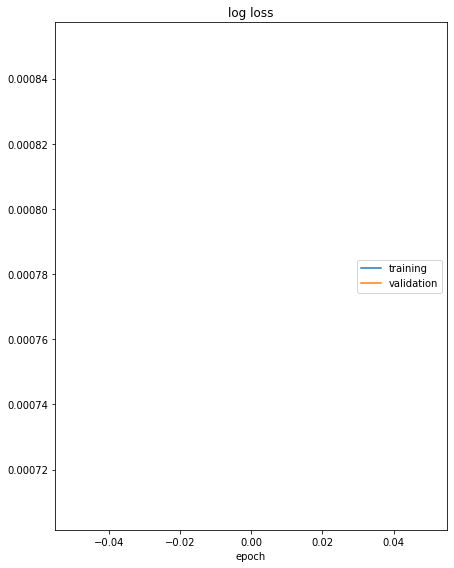

log loss
	training         	 (min:    0.001, max:    0.001, cur:    0.001)
	validation       	 (min:    0.001, max:    0.001, cur:    0.001)
tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>) 1
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward>) 2
tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>) 3
tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>) 4
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>) 5
tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>) 6
tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>) 7
tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>) 8
tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>) 9
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>) 10
tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>) 11
tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>) 12
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>) 13
tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>) 14


KeyboardInterrupt: ignored

In [ ]:
autoencoder = train_model(AEFC2)

In [ ]:
torch.save(AEFC2.state_dict(), "./weightsmc.w")

In [ ]:
AEFC2.load_state_dict(torch.load("weightsmc.w"))

<All keys matched successfully>

In [ ]:
fpcmesh = mesh.Mesh("fpc3.obj",opt=opt)
fpcmesh.init_history()

In [ ]:
print(len(fpcmesh.edges))

10421


In [ ]:
print(fpcmesh.edges)

[[ 109  383]
 [ 108  383]
 [ 108  109]
 ...
 [ 113  114]
 [ 112  113]
 [ 112 3570]]


In [ ]:
print(fpcmesh.edges[2,0])

108


In [ ]:
M = numpy.zeros((10421,3571))

In [ ]:
for i in range(len(fpcmesh.edges)):
  M[i,fpcmesh.edges[i,0]] = 0.5
  M[i,fpcmesh.edges[i,1]] = 0.5

In [ ]:
b = np.array(tocompress[0,0,:].cpu())

In [ ]:
np.shape(b)

(10421,)

In [ ]:
print(np.shape(M))

(10421, 3571)


In [ ]:
x = np.linalg.lstsq(M,b)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [ ]:
print(x)

(array([ 0.00344896,  0.04196855, -0.0014227 , ...,  0.03899728,
        0.01740772,  0.03986315]), array([7.43283011e-15]), 3571, array([1.76380425, 1.75979332, 1.75620738, ..., 0.65549236, 0.65427177,
       0.65415949]))


In [ ]:
vels = open("./csv_data/data_"+ str(20) + ".csv")
velocities = np.loadtxt(vels, delimiter=",")[:,3:5]

FileNotFoundError: ignored

In [ ]:
print(velocities)

[[ 0.00344896 -0.00060597]
 [ 0.04196855 -0.00123742]
 [-0.0014227   0.00017891]
 ...
 [ 0.03899728 -0.00024794]
 [ 0.01740772  0.01590091]
 [ 0.03986315  0.00015168]]


In [ ]:
tocompress = loadfpc(20)

In [ ]:
print(tocompress.size())

torch.Size([1, 2, 10421])


In [ ]:
print(tocompress.size())

torch.Size([1, 2, 10421])


In [ ]:
tocompress = tocompress.to(device)

In [ ]:
tocompress

tensor([[[3.9074e-02, 3.9036e-02, 3.9053e-02,  ..., 4.0041e-02,
          3.9728e-02, 3.9734e-02],
         [3.2951e-05, 2.8814e-05, 2.0752e-05,  ..., 4.9996e-06,
          4.2264e-05, 1.0473e-04]]], device='cuda:0')

In [ ]:
compressed = AEFC2(tocompress.to("cuda"),[fpcmesh])

In [ ]:
print(tocompress-compressed.to("cpu"))

tensor([[[-0.0032, -0.0080, -0.0051,  ..., -0.0061, -0.0049, -0.0074],
         [-0.0327, -0.0329, -0.0227,  ..., -0.0242, -0.0240, -0.0299]]],
       grad_fn=<SubBackward0>)


In [ ]:
print(tocompress.size(),compressed.size())

torch.Size([1, 2, 10421]) torch.Size([1, 2, 10421])
